## Import Package

In [2]:
# required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numba as nb
import warnings
from datetime import datetime
import gc
from utils import *

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor, Pool
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample

# display set up
%matplotlib inline
%precision 4
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)
pd.set_option("display.precision", 3)
pd.options.display.max_rows = 999

/Users/ytchou/opt/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/ytchou/opt/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Load Data

In [4]:
%%time

prop_2016 = pd.read_csv('data/prop_2016_v2.csv')
prop_2016 = reduce_mem_usage(prop_2016)

prop_2017 = pd.read_csv('data/prop_2017_v2.csv')
prop_2017 = reduce_mem_usage(prop_2017)

train = pd.read_csv('data/train_v2.csv')
train = reduce_mem_usage(train)

Mem. usage decreased to 999.27 Mb (75.6% reduction)
Mem. usage decreased to 999.27 Mb (75.6% reduction)
Mem. usage decreased to 58.44 Mb (75.3% reduction)
CPU times: user 4min 14s, sys: 3min 2s, total: 7min 17s
Wall time: 8min 20s


## Modeling Prep

In [5]:
%%time
def encoding(train, prop_2016, prop_2017, categorical_features):
    """
    To limit the value to small numbers since values in categorical_feature is suggested to be small.
    Now the number denoting missing values will be 0 instead of -1.
    """
    from category_encoders import BinaryEncoder
    
    split_index = [len(train), len(prop_2016), len(prop_2017)]
    
    
    prop = pd.concat([train[categorical_features],
                      prop_2016[categorical_features], 
                      prop_2017[categorical_features]], ignore_index=True)
    
    encoder = BinaryEncoder(cols=categorical_features, drop_invariant = True)
    transformed = encoder.fit_transform(prop)
    train_be = transformed.iloc[: split_index[0]].reset_index(drop=True)
    prop_2016_be = transformed.iloc[split_index[0] : split_index[0]+split_index[1]].reset_index(drop=True)
    prop_2017_be = transformed.iloc[split_index[0]+split_index[1]:].reset_index(drop=True)
    

    train = pd.concat([train.drop(columns=categorical_features).reset_index(drop=True), train_be], axis = 1)
    prop_2016 = pd.concat([prop_2016.drop(columns=categorical_features).reset_index(drop=True), prop_2016_be], axis = 1)
    prop_2017 = pd.concat([prop_2017.drop(columns=categorical_features).reset_index(drop=True), prop_2017_be], axis = 1)
    
    train = train.drop(columns = ['trans_month', 'trans_year', 'trans_quarter'])
    
    del prop, transformed, train_be, prop_2016_be, prop_2017_be
    gc.collect()
    return(train, prop_2016, prop_2017)

# Do encoding for cateogircal features
categorical_features = ['airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 'buildingqualitytypeid',
              'fips', 'heatingorsystemtypeid', 'propertycountylandusecode', 'propertylandusetypeid',
              'propertyzoningdesc', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip',
              'storytypeid', 'typeconstructiontypeid', 'geo_cluster']

train, prop_2016, prop_2017 = encoding(train, prop_2016, prop_2017, categorical_features)

CPU times: user 1min 36s, sys: 1min 25s, total: 3min 1s
Wall time: 3min 26s


In [6]:
# Transform to Numpy matrices
X = train.drop(columns=['logerror', 'parcelid', 'transactiondate'])
y = train.logerror.values.astype(float)


# Get categorical features
categorical_indices = []
for i, n in enumerate(X.columns):
    if n in categorical_features:
        categorical_indices.append(i)

# Perform shuffled train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_val shape: {}".format(X_test.shape))
print("y_val shape: {}".format(y_test.shape))

X_train shape: (134310, 211)
y_train shape: (134310,)
X_val shape: (33578, 211)
y_val shape: (33578,)


## Hyperparameter Tuning

We will conduct bayesian hyperparameter tuning with the help of the package `HyperOpt`

In [7]:
# CatBoost parameters Setting
params = {'loss_function': 'MAE',
          'learning_rate': hp.uniform('learning_rate', 0.001, 0.1),
          'depth': hp.choice('depth', np.arange(2, 10, dtype=int)),
          'random_strength': hp.choice('random_strength', np.arange(1, 10, dtype=int)),
         'eval_metric': 'MAE',
         'nan_mode': 'Min',
         'iterations': 1000,
         'od_pval': hp.uniform('od_pval', 0.00001, 0.01),
          'l2_leaf_reg': hp.choice('l2_leaf_reg', [1,3,5,7,11,21,41,81,100]),
          'border_count': hp.choice('border_count', [2,4,8,16,32,64,128,256,512,1024])
         }

In [16]:
def tuning_hyperparam_cat(X, y, num_eval, metric = mean_absolute_error, param = params):
    """
    Wrapper Function for the entire bayesian hyperparameter tuning process. 
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    
    # tuning hyperparameter
    print("Tuning hyperparameter for the output model.")
    t = datetime.now()
    results_hyperopt = hyperopt(param, X_train, y_train, X_test, y_test, num_eval)
    
    # Retrieve Hyperopt scores
    hyperopt_scores = [trial['result']['loss']*-1 for trial in results_hyperopt.trials]
    hyperopt_scores = np.maximum.accumulate(hyperopt_scores)
    
    # plotting
    plot_learning_curve(hyperopt_scores, num_eval = num_eval)
    
    # retrieve best results
    best = results_hyperopt.best_trial['misc']['vals']
    
    clf = CatBoostRegressor(iterations = 10,
                            eval_metric = 'MAE',
                            loss_function = 'MAE',
                            learning_rate = np.float(best['learning_rate'][0]),
                            depth = np.int(best['depth'][0]),
                            random_strength = np.int(best['random_strength'][0]),
                            od_pval = np.float(best['od_pval'][0]),
                            l2_leaf_reg = np.int(best['l2_leaf_reg'][0]),
                            border_count = np.int(best['border_count'][0])
    )
    
    print("Complete.")
    print(f"Time used: {datetime.now() - t}")
    print("")
    return(clf)

In [9]:
def hyperopt(param_space, X_train, y_train, X_test, y_test, num_eval):
    """
    Main hyperparameter tuning function.
    """
    start = time.time()
    
    def objective_function(params):
        clf = CatBoostRegressor(verbose=False, **params).fit(X_train, y_train)
        pred = clf.predict(X_test)
        return {'loss': mean_absolute_error(y_test, pred), 'status': STATUS_OK}

    trials = Trials()
    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials)    
    return(trials)

In [10]:
def plot_learning_curve(hyperopt_scores, num_eval):
    """
    Plot hyperparameter learning curve.
    """
    f, ax = plt.subplots(figsize=(7,6))
    sns.set_palette("husl")
    sns.despine()
    ax = sns.lineplot(x=[x for x in range(num_eval)], y=hyperopt_scores, linewidth = 2)
    plt.title("Finding the optimum", fontsize=18)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Cross-Validation Score (accuracy, %)', fontsize=12)
    plt.legend(loc='lower right', labels=['Hyperopt'])
    plt.setp(ax.get_legend().get_texts(), fontsize='12')

Tuning hyperparameter for the output model.
100%|██████████| 100/100 [1:22:07<00:00, 49.28s/it, best loss: 0.06739697976782728]
Complete.
Time used: 1:22:08.108964



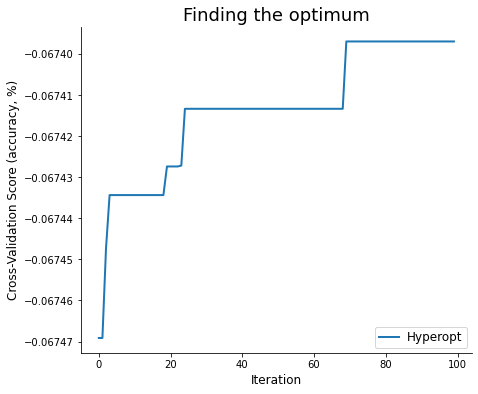

In [20]:
clf = tuning_hyperparam_cat(X_train, y_train, num_eval=100)

In [21]:
params = clf.get_params()
params

{'iterations': 10,
 'learning_rate': 0.0552,
 'depth': 3,
 'l2_leaf_reg': 7,
 'loss_function': 'MAE',
 'border_count': 4,
 'od_pval': 0.0079,
 'random_strength': 2,
 'eval_metric': 'MAE'}

## Training on all Data

In [26]:
# Train multiple models for stacking
from sklearn.model_selection import KFold
n_splits = 3
models = []
params['iterations'] = 10000
skf = KFold(n_splits=n_splits, shuffle=True)
for i, j in enumerate(skf.split(X, y)):
    print("Start training model {}".format(i+1))
    X_train, y_train = X.iloc[j[0]], y[j[0]]
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, verbose=False)
    models.append(model)
    
# Sanity check (make sure scores on a small portion of the dataset are reasonable)
for i, model in enumerate(models):
    print("model {}: {}".format(i, abs(model.predict(X_test) - y_test).mean() * 100))

Start training model 1
Start training model 2
Start training model 3
model 0: 6.7604290535554155
model 1: 6.757296821146125
model 2: 6.7630555654376385


In [27]:
def train_predict_and_export(models, prop_2016, prop_2017, file_name):
    """
    Helper method to make predicition and export results to csv.
    """
    # Construct DataFrame for prediction results
    submission_2016 = pd.DataFrame()
    submission_2017 = pd.DataFrame()
    submission_2016['ParcelId'] = prop_2016.parcelid
    submission_2017['ParcelId'] = prop_2017.parcelid

    # Make Prediction across multiple models
    pred_2016, pred_2017 = [], []
    for i, model in enumerate(models):
        print("Start model {} (2016)".format(i))
        pred_2016.append(model.predict(prop_2016))
        print("Start model {} (2017)".format(i))
        pred_2017.append(model.predict(prop_2017))
    
    # Take average across all models
    mean_pred_2016 = np.mean(pred_2016, axis=0)
    mean_pred_2017 = np.mean(pred_2017, axis=0)
    
    # Formatting for submission
    submission_2016['201610'] = [float(format(x, '.4f')) for x in mean_pred_2016]
    submission_2016['201611'] = submission_2016['201610']
    submission_2016['201612'] = submission_2016['201610']

    submission_2017['201710'] = [float(format(x, '.4f')) for x in mean_pred_2017]
    submission_2017['201711'] = submission_2017['201710']
    submission_2017['201712'] = submission_2017['201710']
    
    submission = pd.merge(submission_2016,submission_2017, how='inner', on='ParcelId')
    submission.to_csv(file_name, index=False)
    print("Submission Successfully Created.")
    return(submission, pred_2016, pred_2017)

In [28]:
%%time
# del train
# gc.collect()

file_name = 'submission/result_cat.csv'
submission, pred_2016, pred_2017 = train_predict_and_export(models, prop_2016, prop_2017, file_name)


Start model 0 (2016)
Start model 0 (2017)
Start model 1 (2016)
Start model 1 (2017)
Start model 2 (2016)
Start model 2 (2017)
Submission Successfully Created.
CPU times: user 8min 42s, sys: 24.5 s, total: 9min 6s
Wall time: 9min 10s


In [39]:
model.save_model('model_CatBoost.py', format='python', pool=X_train)